<a href="https://colab.research.google.com/github/AnushaNatesan/Machine-Learning-Lab/blob/main/Linear-Regression/Linear_Regression_ML_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import the necessary libraries**

In [16]:
# STEP 1: Install kagglehub (if needed)
!pip install kagglehub --quiet

In [17]:
# STEP 2: Import required libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import kagglehub

In [18]:
# STEP 3: Download and Load Dataset
path = kagglehub.dataset_download("phileinsophos/predict-loan-amount-data")
print("Files downloaded:", os.listdir(path))

train_df = pd.read_csv(os.path.join(path, "train.csv"))
test_df = pd.read_csv(os.path.join(path, "test.csv"))

Using Colab cache for faster access to the 'predict-loan-amount-data' dataset.
Files downloaded: ['train.csv', 'test.csv']


In [19]:
# STEP 4: Clean Columns, Drop IDs, Handle Missing
train_df.columns = train_df.columns.str.strip().str.replace(" ", "_").str.replace("(", "", regex=False).str.replace(")", "", regex=False)
test_df.columns = test_df.columns.str.strip().str.replace(" ", "_").str.replace("(", "", regex=False).str.replace(")", "", regex=False)

# Drop unnecessary columns
train_df.drop(columns=['Customer_ID', 'Name', 'Property_ID'], inplace=True, errors='ignore')
test_df.drop(columns=['Customer_ID', 'Name', 'Property_ID'], inplace=True, errors='ignore')

# Define target column
target_col = 'Loan_Sanction_Amount_USD'

# Replace '?' with NaN before filling missing values
train_df.replace('?', np.nan, inplace=True)
test_df.replace('?', np.nan, inplace=True)

# Fill missing values
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)
    else:
        train_df[col].fillna(train_df[col].mean(), inplace=True)

for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col].fillna(train_df[col].mode()[0], inplace=True)
    else:
        test_df[col].fillna(train_df[col].mean(), inplace=True)

/tmp/ipython-input-452152434.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].mode()[0], inplace=True)
/tmp/ipython-input-452152434.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [20]:
# STEP 5: Encode Categorical Columns using same LabelEncoders
label_encoders = {}
# Identify categorical columns again after filling missing values
cat_cols = train_df.select_dtypes(include='object').columns

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])

    # Replace unseen labels in test data with '<UNK>'
    test_df[col] = test_df[col].apply(lambda x: x if x in le.classes_ else '<UNK>')
    le.classes_ = np.append(le.classes_, '<UNK>')
    test_df[col] = le.transform(test_df[col])

    label_encoders[col] = le

# Ensure all columns are numeric before scaling
for col in train_df.columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
for col in test_df.columns:
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

# Fill any NaNs introduced by coercion (if any)
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

In [21]:
# STEP 6: Feature Scaling and Split
X = train_df.drop(target_col, axis=1)
y = train_df[target_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:
# STEP 7: Train and Evaluate Model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("Model Evaluation on Validation Set:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

Model Evaluation on Validation Set:
MAE: 21707.34894824274
MSE: 981775294.9074459
RMSE: 31333.29371303703
R2 Score: 0.572943185067988


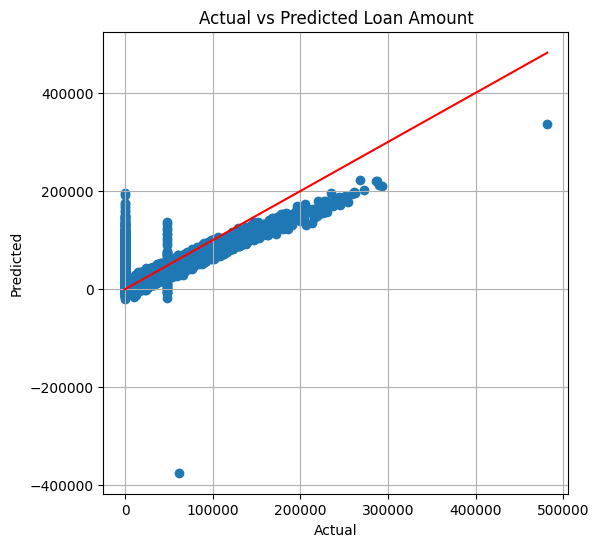

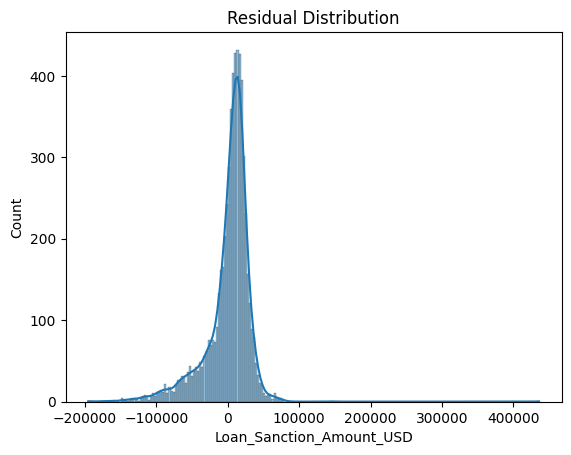

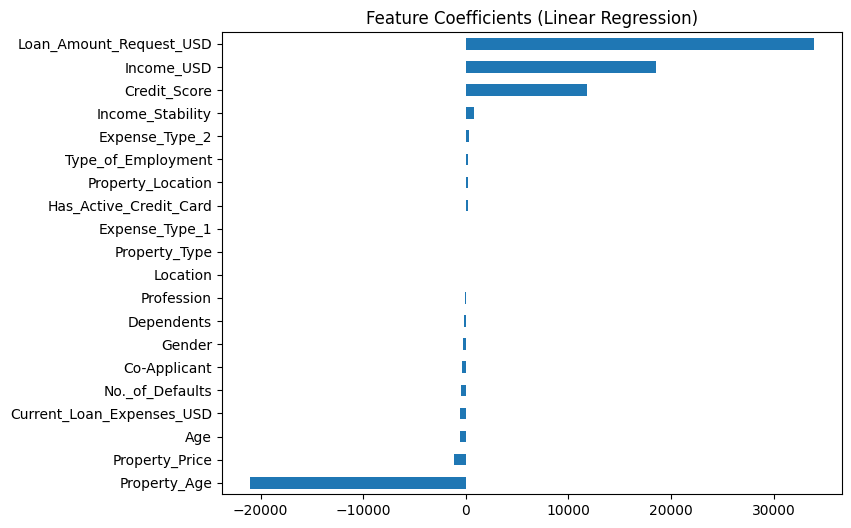

In [23]:
# STEP 8: Visualizations
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Loan Amount")
plt.grid(True)
plt.show()

residuals = y_val - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

coef_df = pd.Series(model.coef_, index=X.columns)
coef_df.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Coefficients (Linear Regression)")
plt.show()

In [24]:
# STEP 9: Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

mae_cv = -cross_val_score(model, X_scaled, y, scoring='neg_mean_absolute_error', cv=cv)
mse_cv = -cross_val_score(model, X_scaled, y, scoring='neg_mean_squared_error', cv=cv)
r2_cv = cross_val_score(model, X_scaled, y, scoring='r2', cv=cv)

print("\nCross-Validation Scores:")
for i in range(5):
    print(f"Fold {i+1}: MAE={mae_cv[i]:.2f}, MSE={mse_cv[i]:.2f}, R2={r2_cv[i]:.2f}")

print("\nAverage MAE:", mae_cv.mean())
print("Average MSE:", mse_cv.mean())
print("Average R2:", r2_cv.mean())


Cross-Validation Scores:
Fold 1: MAE=21707.35, MSE=981775294.91, R2=0.57
Fold 2: MAE=21872.18, MSE=979577829.23, R2=0.57
Fold 3: MAE=22364.06, MSE=1064344947.87, R2=0.54
Fold 4: MAE=21752.63, MSE=992875407.17, R2=0.58
Fold 5: MAE=21005.40, MSE=879901819.13, R2=0.61

Average MAE: 21740.323013950943
Average MSE: 979695059.6602628
Average R2: 0.5739754495958775


In [25]:
# STEP 10: Predict on Test Set
X_test = test_df[X.columns]  # same order
X_test_scaled = scaler.transform(X_test)

test_predictions = model.predict(X_test_scaled)
test_df['Predicted_Loan_Amount'] = test_predictions
test_df[['Predicted_Loan_Amount']].to_csv("loan_predictions.csv", index=False)

print("\n✅ Predictions saved to loan_predictions.csv")


✅ Predictions saved to loan_predictions.csv


## AdaBoost Regressor

In [26]:
from sklearn.ensemble import AdaBoostRegressor

# Initialize and train AdaBoost Regressor
adaboost_model = AdaBoostRegressor(random_state=42)
adaboost_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_adaboost = adaboost_model.predict(X_val)

mae_adaboost = mean_absolute_error(y_val, y_pred_adaboost)
mse_adaboost = mean_squared_error(y_val, y_pred_adaboost)
rmse_adaboost = np.sqrt(mse_adaboost)
r2_adaboost = r2_score(y_val, y_pred_adaboost)

print("AdaBoost Model Evaluation on Validation Set:")
print("MAE:", mae_adaboost)
print("MSE:", mse_adaboost)
print("RMSE:", rmse_adaboost)
print("R2 Score:", r2_adaboost)

AdaBoost Model Evaluation on Validation Set:
MAE: 27036.819127091076
MSE: 1164337414.3424592
RMSE: 34122.388754928324
R2 Score: 0.4935315338912245


## XGBoost Regressor

In [27]:
from xgboost import XGBRegressor

# Initialize and train XGBoost Regressor
# You might need to install xgboost: !pip install xgboost
xgboost_model = XGBRegressor(random_state=42)
xgboost_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgboost = xgboost_model.predict(X_val)

mae_xgboost = mean_absolute_error(y_val, y_pred_xgboost)
mse_xgboost = mean_squared_error(y_val, y_pred_xgboost)
rmse_xgboost = np.sqrt(mse_xgboost)
r2_xgboost = r2_score(y_val, y_pred_xgboost)

print("XGBoost Model Evaluation on Validation Set:")
print("MAE:", mae_xgboost)
print("MSE:", mse_xgboost)
print("RMSE:", rmse_xgboost)
print("R2 Score:", r2_xgboost)

XGBoost Model Evaluation on Validation Set:
MAE: 12662.483723447223
MSE: 600158682.4602714
RMSE: 24498.13630585542
R2 Score: 0.7389404105860717


## Gradient Boosting Regressor

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train Gradient Boosting Regressor
gradient_boosting_model = GradientBoostingRegressor(random_state=42)
gradient_boosting_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = gradient_boosting_model.predict(X_val)

mae_gb = mean_absolute_error(y_val, y_pred_gb)
mse_gb = mean_squared_error(y_val, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_val, y_pred_gb)

print("Gradient Boosting Model Evaluation on Validation Set:")
print("MAE:", mae_gb)
print("MSE:", mse_gb)
print("RMSE:", rmse_gb)
print("R2 Score:", r2_gb)

Gradient Boosting Model Evaluation on Validation Set:
MAE: 13762.141706334874
MSE: 577926704.2643478
RMSE: 24040.106161669664
R2 Score: 0.7486109715048858


## Support Vector Regressor (SVR)

In [31]:
from sklearn.svm import SVR

# Initialize and train Support Vector Regressor
# SVR can be computationally expensive and may take some time to run
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svr = svr_model.predict(X_val)

mae_svr = mean_absolute_error(y_val, y_pred_svr)
mse_svr = mean_squared_error(y_val, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_val, y_pred_svr)

print("Support Vector Regressor Model Evaluation on Validation Set:")
print("MAE:", mae_svr)
print("MSE:", mse_svr)
print("RMSE:", rmse_svr)
print("R2 Score:", r2_svr)

Support Vector Regressor Model Evaluation on Validation Set:
MAE: 36512.25236774447
MSE: 2391799423.1526895
RMSE: 48906.0264502514
R2 Score: -0.04039513818088469


## Ridge Regressor

In [32]:
from sklearn.linear_model import Ridge

# Initialize and train Ridge Regressor
ridge_model = Ridge(random_state=42)
ridge_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ridge = ridge_model.predict(X_val)

mae_ridge = mean_absolute_error(y_val, y_pred_ridge)
mse_ridge = mean_squared_error(y_val, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_val, y_pred_ridge)

print("Ridge Model Evaluation on Validation Set:")
print("MAE:", mae_ridge)
print("MSE:", mse_ridge)
print("RMSE:", rmse_ridge)
print("R2 Score:", r2_ridge)

Ridge Model Evaluation on Validation Set:
MAE: 21707.578426521723
MSE: 981407718.4699271
RMSE: 31327.427575048787
R2 Score: 0.5731030750381931


## Lasso Regressor

In [33]:
from sklearn.linear_model import Lasso

# Initialize and train Lasso Regressor
lasso_model = Lasso(random_state=42)
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_val)

mae_lasso = mean_absolute_error(y_val, y_pred_lasso)
mse_lasso = mean_squared_error(y_val, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_val, y_pred_lasso)

print("Lasso Model Evaluation on Validation Set:")
print("MAE:", mae_lasso)
print("MSE:", mse_lasso)
print("RMSE:", rmse_lasso)
print("R2 Score:", r2_lasso)

Lasso Model Evaluation on Validation Set:
MAE: 21708.683989324807
MSE: 981281765.4624248
RMSE: 31325.417243229575
R2 Score: 0.5731578626158538


## Compare the performance of all the algorithms


In [34]:
# Create a dictionary to hold the model names and their metrics
model_performance = {
    'Model': ['Linear Regression', 'AdaBoost Regressor', 'XGBoost Regressor', 'Gradient Boosting Regressor', 'SVR', 'Ridge Regressor', 'Lasso Regressor'],
    'MAE': [mae, mae_adaboost, mae_xgboost, mae_gb, mae_svr, mae_ridge, mae_lasso],
    'MSE': [mse, mse_adaboost, mse_xgboost, mse_gb, mse_svr, mse_ridge, mse_lasso],
    'RMSE': [rmse, rmse_adaboost, rmse_xgboost, rmse_gb, rmse_svr, rmse_ridge, rmse_lasso],
    'R2 Score': [r2, r2_adaboost, r2_xgboost, r2_gb, r2_svr, r2_ridge, r2_lasso]
}

# Create a DataFrame from the dictionary
performance_df = pd.DataFrame(model_performance)

# Display the DataFrame
display(performance_df)

,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression,21707.348948,9.817753e+08,31333.293713,0.572943
1,AdaBoost Regressor,27036.819127,1.164337e+09,34122.388755,0.493532
2,XGBoost Regressor,12662.483723,6.001587e+08,24498.136306,0.738940
3,Gradient Boosting Regressor,13762.141706,5.779267e+08,24040.106162,0.748611
4,SVR,36512.252368,2.391799e+09,48906.026450,-0.040395
5,Ridge Regressor,21707.578427,9.814077e+08,31327.427575,0.573103
6,Lasso Regressor,21708.683989,9.812818e+08,31325.417243,0.573158


## Visualize ridge and lasso results

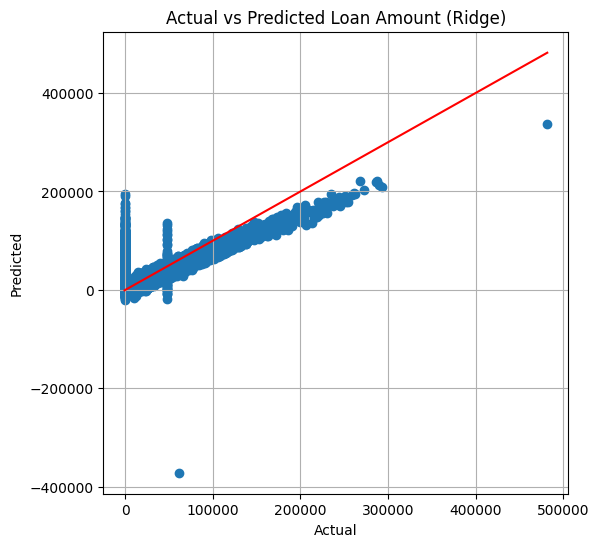

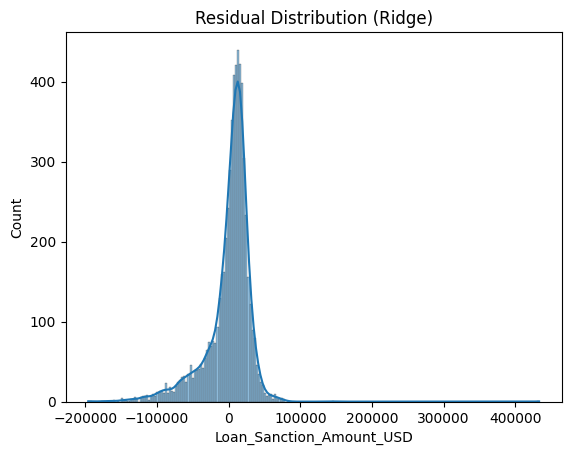

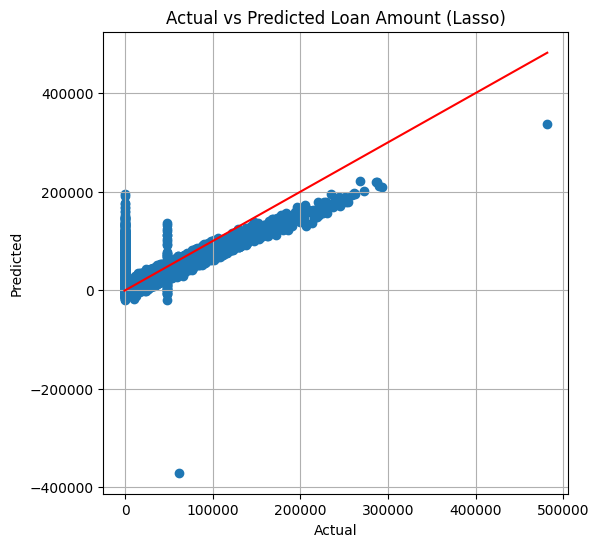

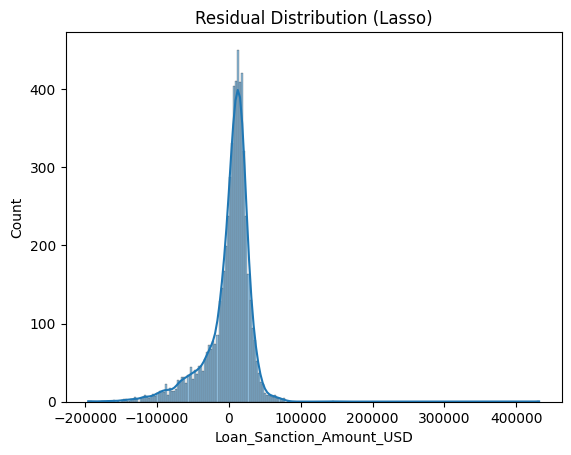

In [35]:
# Plot for Ridge Regressor: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_ridge)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Loan Amount (Ridge)")
plt.grid(True)
plt.show()

# Plot for Ridge Regressor: Residual Distribution
residuals_ridge = y_val - y_pred_ridge
sns.histplot(residuals_ridge, kde=True)
plt.title("Residual Distribution (Ridge)")
plt.show()

# Plot for Lasso Regressor: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_lasso)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Loan Amount (Lasso)")
plt.grid(True)
plt.show()

# Plot for Lasso Regressor: Residual Distribution
residuals_lasso = y_val - y_pred_lasso
sns.histplot(residuals_lasso, kde=True)
plt.title("Residual Distribution (Lasso)")
plt.show()

## Hyperparameter tuning



In [36]:
# Identify top performing models (XGBoost and Gradient Boosting based on R2 score)
top_models = {
    'XGBoost': XGBRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Define hyperparameter grids for tuning
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }
}

**Reasoning**:
Perform hyperparameter tuning using GridSearchCV for the selected top models and print the best parameters found.



In [37]:
from sklearn.model_selection import GridSearchCV

tuned_models = {}

for name, model in top_models.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(model, param_grids[name], scoring='r2', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    tuned_models[name] = grid_search
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Tuning Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


**Reasoning**:
Evaluate the performance of the best tuned models on the validation set and report the metrics.



In [38]:
# Evaluate the best tuned models
for name, grid_search in tuned_models.items():
    best_model = grid_search.best_estimator_
    y_pred_tuned = best_model.predict(X_val)

    mae_tuned = mean_absolute_error(y_val, y_pred_tuned)
    mse_tuned = mean_squared_error(y_val, y_pred_tuned)
    rmse_tuned = np.sqrt(mse_tuned)
    r2_tuned = r2_score(y_val, y_pred_tuned)

    print(f"\nTuned {name} Model Evaluation on Validation Set:")
    print("MAE:", mae_tuned)
    print("MSE:", mse_tuned)
    print("RMSE:", rmse_tuned)
    print("R2 Score:", r2_tuned)


Tuned XGBoost Model Evaluation on Validation Set:
MAE: 12238.50485615623
MSE: 542832870.1522307
RMSE: 23298.77400534695
R2 Score: 0.7638762374953952

Tuned Gradient Boosting Model Evaluation on Validation Set:
MAE: 12136.010105817
MSE: 548391802.1229528
RMSE: 23417.766804777795
R2 Score: 0.7614581895019752


In [39]:
# Select the best overall model (tuned XGBoost based on R2 score)
best_model = tuned_models['XGBoost'].best_estimator_

# Predict on the scaled test data
test_predictions = best_model.predict(X_test_scaled)

# Add predictions to the original test_df
# Ensure the index of test_df is aligned with the predictions if necessary,
# but since we are adding a new column, pandas aligns by index by default.
test_df['Predicted_Loan_Amount'] = test_predictions

# Save the test_df with predictions to a CSV file
test_df[['Predicted_Loan_Amount']].to_csv("loan_predictions.csv", index=False)

print("\n✅ Predictions saved to loan_predictions.csv using the best model (tuned XGBoost).")


✅ Predictions saved to loan_predictions.csv using the best model (tuned XGBoost).
